In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random
import pandas as pd

In [17]:
# Constants
g = 9.81                            # Gravity (m/s^2)

# Metronome Parameters
m_pendulum = 0.1                 # Mass of pendulum (kg)
L1_pendulum = 0.3                   # Length of first pendulum (m)
L2_pendulum = 0.3                   # Length of second pendulum (m)
L3_pendulum = 0.3                   # Length of first pendulum (m)
L4_pendulum = 0.3                   # Length of second pendulum (m)

epsilon = 0.15                      # Escapement force coefficient

theta1_0_init=theta1_0 = 0.9        # Initial position of metronome 1
theta2_0_init=theta2_0 = 0.25       # Initial position of metronome 2
theta3_0_init=theta3_0 = 0.75        # Initial position of metronome 1
theta4_0_init=theta4_0 = 0.5       # Initial position of metronome 2

I1 = m_pendulum * L1_pendulum**2    # Inertia of first pendulum
I2 = m_pendulum * L2_pendulum**2    # Inertia of second pendulum
I3 = m_pendulum * L3_pendulum**2    # Inertia of first pendulum
I4 = m_pendulum * L4_pendulum**2    # Inertia of second pendulum


# Cart Parameters
M_cart = 1.0                        # Mass of the cart (kg)


# Initial Conditions (Angles in radians)
omega1_0 = 0                      # Initial angular velocity
omega2_0 = 0                      # Initial angular velocity
omega3_0 = 0                      # Initial angular velocity
omega4_0 = 0                      # Initial angular velocity

x_0 = 0.0                           # Initial displacement of the surface
v_0 = 0.0                           # Initial velocity of the surface



In [3]:
def metronome_matrix_system(t, y, kd, kp):
    theta1 , omega1, theta2, omega2, theta3, omega3, theta4, omega4, x, v = y  # Unpack state variables
    

    # Mass Matrix M(q)
    M_q = np.array([
        [I1, 0, 0, 0, m_pendulum * L1_pendulum * np.cos(theta1)],
        [0, I2, 0, 0, m_pendulum * L2_pendulum * np.cos(theta2)],
        [0, 0, I3, 0, m_pendulum * L3_pendulum * np.cos(theta3)],
        [0, 0, 0, I4, m_pendulum * L4_pendulum * np.cos(theta4)],
        [m_pendulum * L1_pendulum * np.cos(theta1), m_pendulum * L2_pendulum * np.cos(theta2), 
         m_pendulum * L3_pendulum * np.cos(theta3), m_pendulum * L4_pendulum * np.cos(theta4), 
         M_cart + 4 * m_pendulum]
    ])

    # Coriolis Matrix C(q, q_dot)
    C_q_qdot = np.array([
        [epsilon * ((theta1 / theta1_0)**2 - 1) * m_pendulum * (L1_pendulum**2), 0, 0, 0, 0],
        [0, epsilon * ((theta2 / theta2_0)**2 - 1) * m_pendulum * (L2_pendulum**2), 0, 0, 0],
        [0, 0, epsilon * ((theta3 / theta3_0)**2 - 1) * m_pendulum * (L3_pendulum**2), 0, 0],
        [0, 0, 0, epsilon * ((theta4 / theta4_0)**2 - 1) * m_pendulum * (L4_pendulum**2), 0],
        [m_pendulum * L1_pendulum * np.sin(theta1) * omega1, m_pendulum * L2_pendulum * np.sin(theta2) * omega2,
         m_pendulum * L3_pendulum * np.sin(theta3) * omega3, m_pendulum * L4_pendulum * np.sin(theta4) * omega4, 0],
    ])

    # Gravity Matrix G(q)
    G_q = np.array([
        [m_pendulum * g * L1_pendulum * np.sin(theta1)],
        [m_pendulum * g * L2_pendulum * np.sin(theta2)],
        [m_pendulum * g * L3_pendulum * np.sin(theta3)],
        [m_pendulum * g * L4_pendulum * np.sin(theta4)],
        [0]  # Gravity does not affect cart directly
    ])

       # Feedback Linearization Control: Track Metronome 1's motion
    kd1 = kd2 = kd3 = kd
    kp1 = kp2 = kp3 = kp
    Kp_FB = np.diag([kp1, kp2, kp3, kp2, kp3])    # proportional gain for feedback linearization
    Kd_FB = np.diag([kd1, kd2, kd3, kp2, kp3])    # derivative gain for feedback linearization

    q_d = [theta1 ,theta1,theta1 ,theta1,-theta1]      # displacement of metronome 1
    qq =[omega1,omega1,omega1,omega1,-omega1]         # velocity of metronome 1

    q_tilde = q_d - np.array([[theta1], [theta2],[theta3], [theta4],[x]])         # displacement error between cart and metronome
    q_tilde_dot = qq - np.array([[omega1], [omega2],[omega3], [omega4] ,[v]])      # velocity error between cart and metronome
    v_control = Kp_FB @  q_tilde+ Kd_FB @ q_tilde_dot

    # control law u
    tau_input = (M_q @ v_control + C_q_qdot @ np.array([[omega1], [omega2],[omega3], [omega4], [v]]) + G_q)[2, 0]

    # Control input vector
    tau = np.array([
        [0],
        [0],
        [0],
        [0],
        [tau_input]
    ])
    #print("M_q shape:", M_q.shape)
    #print("C_q_qdot shape:", C_q_qdot.shape)
    #print("G_q shape:", G_q.shape)
    #print("tau shape:", tau.shape)

    # Solve for accelerations
    q_ddot = np.linalg.solve(M_q, (tau - np.dot(C_q_qdot, np.array([[omega1], [omega2], [omega3], [omega4], [v]])) - G_q))

    return [omega1, q_ddot[0, 0], omega2, q_ddot[1, 0], omega3, q_ddot[2, 0], omega4, q_ddot[3, 0], v, q_ddot[4, 0]]

In [24]:
class solver():
    def __init__(self, kd, kp, T_max=50):
        self.kd = kd
        self.kp = kp
        self.T_max = T_max

        self.time = []
        self.theta1 = []
        self.qdd1 = []
        self.theta2 = []
        self.qdd2 = []
        self.theta3 = []
        self.qdd3 = []
        self.theta4 = []
        self.qdd4 = []

        
        self.surface_x = []
        self.qdd5 = []

        self.sync_time = -1
        self.sync_threshold = -1

    def solve(self, dt=0.01):
        t_span = (0, self.T_max)
        y0 = [theta1_0_init, omega1_0, theta2_0_init, omega2_0,theta3_0_init, omega3_0, theta4_0_init, omega4_0 ,x_0, v_0]
        t_eval = np.arange(0, self.T_max, dt)
        #print("y0:", y0)
        #print("Length of y0:", len(y0))

        sol = solve_ivp(metronome_matrix_system, t_span, y0, args=[self.kd, self.kp], t_eval=t_eval, method="RK45")
        


        # Extract solutions
        self.time = sol.t                # time
        self.theta1 = sol.y[0]           # angle of metronome 1
        self.qdd1 = sol.y[1]             # acceleration of metronome 1
        self.theta2 = sol.y[2]           # angle of metronome 1
        self.qdd2 = sol.y[3]             # acceleration of metronome 2
        self.theta3 = sol.y[4]           # angle of metronome 1
        self.qdd3 = sol.y[5]             # acceleration of metronome 1
        self.theta4 = sol.y[6]           # angle of metronome 1
        self.qdd4 = sol.y[7]
        self.surface_x = sol.y[8]        # Surface displacement
        self.qdd5 = sol.y[9]             # acceleration of cart

        return self

    def find_sync_time(self, sync_threshold=1.0):
        """
        find the sync time for the metronomes to a set accuracy or lower - if accuracy cannot be 
        reached, reduce by 0.05 until an accuracy is reached. records both time and accuracy.

        sync is determined if the average value of the phase diff of the two metronomes for the prior 3 seconds
        are within the threshold synchronicity set. returns the value of 3 seconds ago where the sync began

        Args:
            sync_threshold (float, optional): sync threshold (0 - 1). Defaults to 1.0.

        Returns:
            floats: threshold, time to sync     
            # redundant since the model attributes are filled anyway, left for compatability with old code
        """
        sync = False
        while not sync:
            for t in range(300, len(self.time)):
                #phase_diff = np.abs(self.theta1[t-300:t] - self.theta2[t-300:t])
                #avg_sync = np.mean(1 - phase_diff)
                phase_diff1 = np.abs(self.theta1[t-300:t] - self.theta2[t-300:t])
                phase_diff2 = np.abs(self.theta1[t-300:t] - self.theta3[t-300:t])
                phase_diff3 = np.abs(self.theta1[t-300:t] - self.theta4[t-300:t])

                phase_diff11 = np.abs(self.theta2[t-300:t] - self.theta1[t-300:t])
                phase_diff21 = np.abs(self.theta2[t-300:t] - self.theta3[t-300:t])
                phase_diff31 = np.abs(self.theta2[t-300:t] - self.theta4[t-300:t])

                phase_diff12 = np.abs(self.theta3[t-300:t] - self.theta2[t-300:t])
                phase_diff22 = np.abs(self.theta3[t-300:t] - self.theta1[t-300:t])
                phase_diff32 = np.abs(self.theta3[t-300:t] - self.theta4[t-300:t])
                avg_sync = np.mean(1 - ((phase_diff1 + phase_diff2 + phase_diff3) + 
                                        (phase_diff11 + phase_diff21 + phase_diff31) + 
                                        (phase_diff12 + phase_diff22 + phase_diff32))/ 4)

                # adjust this to increase threshold for synchronicity
                if avg_sync >= sync_threshold:
                    #print(f"Synched at {self.time[t-300]} with synch {avg_sync}")
                    sync = True
                    self.sync_time = self.time[t-300]
                    self.sync_threshold = sync_threshold
                    return sync_threshold, self.time[t-300]
                
            sync_threshold -= 0.05


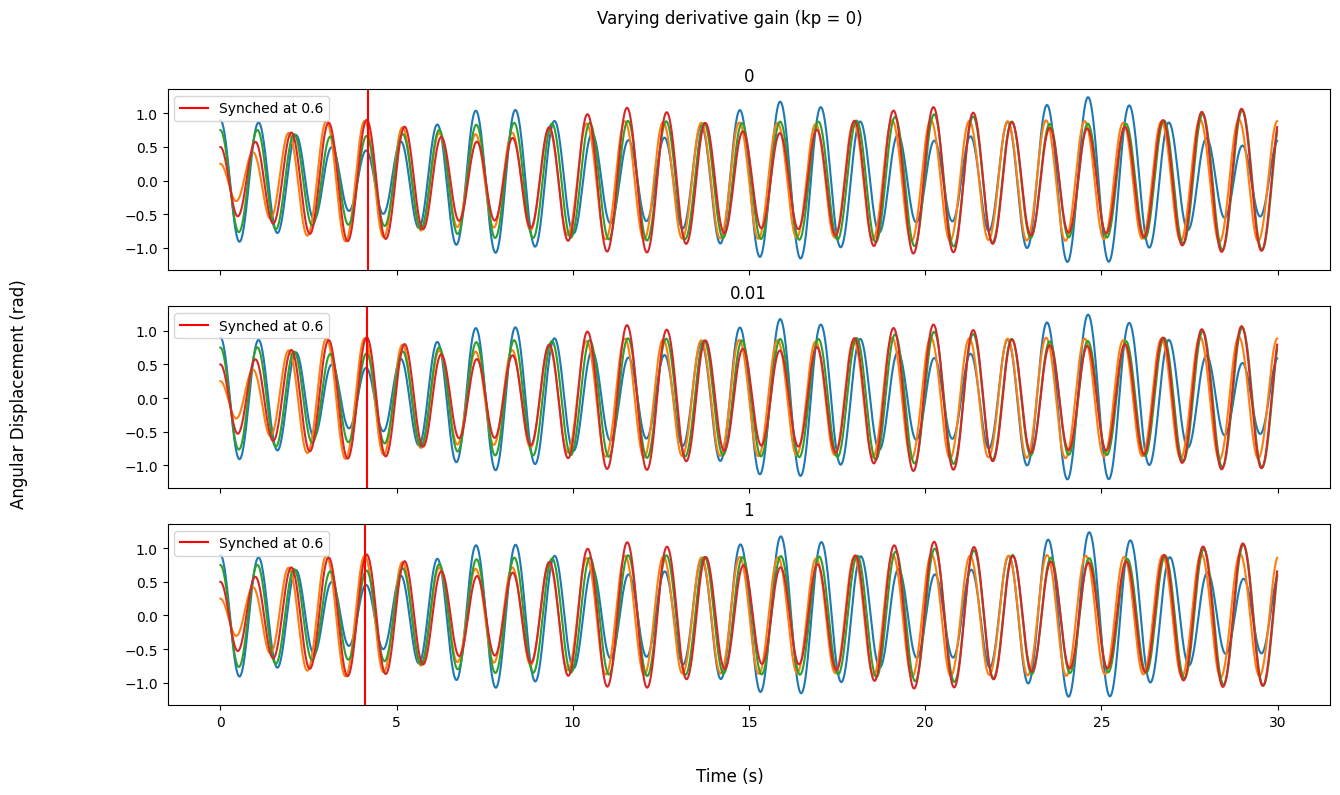

In [25]:
kp = 0          #2 to 5(solver, 1.3333333, 25.5, 20)
kd = 0

fig1, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(15, 8))
#plt.xlim(1,6)
fig1.supxlabel("Time (s)")
fig1.supylabel("Angular Displacement (rad)")
plt.suptitle(f"Varying derivative gain (kp = {kp})")
#plt.legend()
#plt.grid()
t = 30
kds = [0,0.01,1]
for kd, ax in zip(kds, (ax1, ax2, ax3)):
    model = solver(kd, kp, t)
    model.solve()
    model.find_sync_time()
    ax.set_title(kd)
    
    #ax.plot(model.time,a*np.sin(w*model.time) , label="desire traject", color='black')#tring to make a the model follow a sine wave instead of following theta 1
    #ax.plot(model.time,0*a*np.sin(w*model.time) , label="desire traject", color='black')

    ax.plot(model.time, model.theta1) #, label="Metronome 1", color='g')
    ax.plot(model.time, model.theta2) #, label="Metronome 2", color='b')
    ax.plot(model.time, model.theta3) #, label="Metronome 3", color='r')
    ax.plot(model.time, model.theta4) #, label="Metronome 4", color='y')
    ax.axvline(model.sync_time, c="r", label=f"Synched at {model.sync_threshold:.1f}")
    ax.legend()

plt.xlim()

#plt.ylim(-4,4)
plt.show()